In [67]:
import os
from datetime import datetime

import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import alexnet, resnet50
from torchvision.transforms import functional as F
from xml.etree import ElementTree as ET
import pandas as pd
from PIL import Image

from torchmetrics import Accuracy
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter



In [68]:

class VOCDataset(torch.utils.data.Dataset):
    
    CLASS_NAMES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    class_to_idx = {class_name: idx for idx, class_name in enumerate(CLASS_NAMES)}
        
    
    def __init__(self, root_dir, year='2012', image_set='train', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and annotations.
            year (string): Year of the PASCAL VOC dataset.
            image_set (string): 'train', 'val', or 'trainval'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.year = year
        self.image_set = image_set
        self.transform = transform
        self.data_path = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'ImageSets', 'Main', f'{image_set}.txt')
        self.img_path = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'JPEGImages')
        self.anno_path = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'Annotations')
        with open(self.data_path) as f:
            self.img_ids = f.read().splitlines()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_file = os.path.join(self.img_path, f'{img_id}.jpg')
        anno_file = os.path.join(self.anno_path, f'{img_id}.xml')

        # Parse XML annotation
        tree = ET.parse(anno_file)
        root = tree.getroot()
        
        objects = []
        for obj in root.iter('object'):
            class_name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            objects.append((class_name, (xmin, ymin, xmax, ymax)))
        
        # Example: using the first object per image for simplicity
        if len(objects) > 0:
            class_name, (xmin, ymin, xmax, ymax) = objects[0]
            image = Image.open(img_file).convert('RGB')
            image = image.crop((xmin, ymin, xmax, ymax))
            
            if self.transform:
                image = self.transform(image)
            
            label = class_to_idx[class_name]
            # Convert class_name to a numerical label if needed
            
            return image, label




In [69]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize VOCDataset
voc_dataset = VOCDataset(root_dir='./data', year='2012', image_set='train', transform=transform)

# transform for ResNet50
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [57]:
# Training set
train_dataset = VOCDataset(root_dir='./data', year='2012', image_set='train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

# Validation set
val_dataset = VOCDataset(root_dir='./data', year='2012', image_set='val', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)


In [58]:
images, labels = next(iter(train_loader))

In [59]:
labels

tensor([19,  8, 11, 14])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


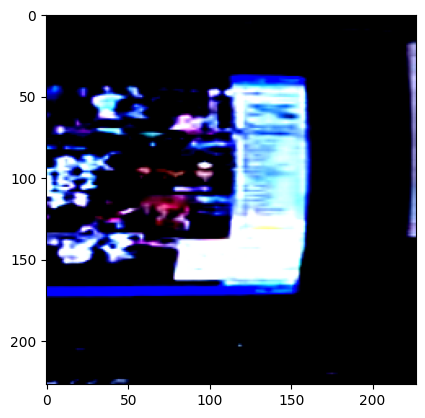

In [60]:
# pytorch tensor to numpy array
images[0].permute(1, 2, 0).numpy().shape

# Display image
import matplotlib.pyplot as plt

plt.imshow(images[0].permute(1, 2, 0).numpy())

In [75]:
# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [77]:
resnet50_model = resnet50(weights=True)


# summary(model=resnet50_model, input_size=(1, 3, 227, 227), col_width=20,
#                   col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

# Optionally, freeze the weights of the early layers. Here we freeze all but the last 2 layers.
for name, param in resnet50_model.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False

# Replace the final fully connected layer to fit the number of classes in the PASCAL VOC dataset
num_classes = 20  # 20 object classes + 1 background class
resnet50_model.fc = torch.nn.Linear(resnet50_model.fc.in_features, num_classes)


resnet_model = resnet50_model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# Only optimize the parameters that require gradients
optimizer_sgd_resnet = optim.SGD(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001, momentum=0.9)



optimizer_adam_resnet = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=1e-4)


In [61]:

# Load a pre-trained AlexNet model
alexnet_model = alexnet(weights=True)


# alexnet_model_all_layers = alexnet(weights=True)

accuracy = Accuracy(task='multiclass', num_classes=20)



# Optionally, freeze the weights of the early layers and only fine-tune the higher-level layers
for param in resnet50_model.features.parameters():
    param.requires_grad = False

# Replace the classifier with a new one for the number of classes in PASCAL VOC (plus background)
num_classes = 20  # 20 object classes + 1 background class
alexnet_model.classifier[6] = torch.nn.Linear(alexnet_model.classifier[6].in_features, num_classes)

# Move model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model = alexnet_model.to(device)
accuracy = accuracy.to(device)

# Define your loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_model.classifier.parameters(), lr=0.001, momentum=0.9)

optimizer_adam = optim.Adam(alexnet_model.classifier.parameters(), lr=1e-4)


m:\ML\ML_regs\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
summary(model=alexnet_model, input_size=(1, 3, 227, 227), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [1, 3, 227, 227]     [1, 20]              --                   Partial
├─Sequential (features)                  [1, 3, 227, 227]     [1, 256, 6, 6]       --                   False
│    └─Conv2d (0)                        [1, 3, 227, 227]     [1, 64, 56, 56]      (23,296)             False
│    └─ReLU (1)                          [1, 64, 56, 56]      [1, 64, 56, 56]      --                   --
│    └─MaxPool2d (2)                     [1, 64, 56, 56]      [1, 64, 27, 27]      --                   --
│    └─Conv2d (3)                        [1, 64, 27, 27]      [1, 192, 27, 27]     (307,392)            False
│    └─ReLU (4)                          [1, 192, 27, 27]     [1, 192, 27, 27]     --                   --
│    └─MaxPool2d (5)                     [1, 192, 27, 27]     [1, 192, 13, 13]     --                   --
│    └─Conv2d (6

In [78]:
# Track the loss and accuracy
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = f'Resnet50_PASCAL_VOC_{timestamp}'
model_name = 'ResNetRCNN'
log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
log_writer = SummaryWriter(log_dir=log_dir)

In [79]:
for epoch in range(5):  # loop over the dataset multiple times
    train_loss, train_acc = 0, 0
    cumulative_batch = 0

    print(f'Epoch {epoch+1}')
    for X, y in train_loader:
        
        resnet_model.train()
        X, y = X.to(device), y.to(device)

        y_pred = resnet_model(X)

        loss = criterion(y_pred, y)
        train_loss += loss.item()

        acc = accuracy(y_pred, y)
        train_acc += acc

        optimizer_adam_resnet.zero_grad()
        loss.backward()
        optimizer_adam_resnet.step()
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    val_loss, val_acc = 0, 0
    resnet_model.eval()

    with torch.inference_mode():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            y_pred = resnet_model(X)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            acc = accuracy(y_pred, y)
            val_acc += acc
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)


    log_writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    log_writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

Epoch 1
Epoch 1, Loss: 0.9979, Accuracy: 0.7168
Val Loss: 0.5334, Val Accuracy: 0.8650
Epoch 2
Epoch 2, Loss: 0.5230, Accuracy: 0.8502
Val Loss: 0.4975, Val Accuracy: 0.8771
Epoch 3
Epoch 3, Loss: 0.3456, Accuracy: 0.9030
Val Loss: 0.5204, Val Accuracy: 0.8748
Epoch 4
Epoch 4, Loss: 0.2693, Accuracy: 0.9210
Val Loss: 0.5367, Val Accuracy: 0.8743
Epoch 5
Epoch 5, Loss: 0.2286, Accuracy: 0.9346
Val Loss: 0.6253, Val Accuracy: 0.8681


In [80]:
torch.save(resnet_model.state_dict(), 'resnet50_pascal_voc.pth')